# Assignment 2: Build a CNN for image recognition.

## Due Date:  March 29, 11:59PM

### Name: Abhishek Panda


## Introduction:

1. In this assignment, you will build Convolutional Neural Network to classify CIFAR-10 Images.
2. You can directly load dataset from many deep learning packages.
3. You can use any deep learning packages such as pytorch, keras or tensorflow for this assignment.

## Requirements:

1. You need to load cifar 10 data and split the entire training dataset into training and validation.
2. You will implement a CNN model to classify cifar 10 images with provided structure.
3. You need to plot the training and validation accuracy or loss obtained from above step.
4. Then you can use tuned parameters to train using the entire training dataset.
5. You should report the testing accuracy using the model with complete data.
6. You may try to change the structure (e.g, add BN layer or dropout layer,...) and analyze your findings.

## Google Colab

- If you do not have GPU, the training of a CNN can be slow. Google Colab is a good option.

## Batch Normalization (BN)

### Background:

- Batch Normalization is a technique to speed up training and help make the model more stable.
- In simple words, batch normalization is just another network layer that gets inserted between a hidden layer and the next hidden layer. Its job is to take the outputs from the first hidden layer and normalize them before passing them on as the input of the next hidden layer.

- For more detailed information, you may refer to the original paper: https://arxiv.org/pdf/1502.03167.pdf.

### BN Algorithm:

- Input: Values of $x$ over a mini-batch: $\mathbf{B}$ = $\{x_1,..., x_m\};$
- Output: $\{y_i = BN_{\gamma,\beta}(x_i)\}$, $\gamma, \beta$ are learnable parameters

Normalization of the Input:
$$\mu_{\mathbf{B}} = \frac{1}{m}\sum_{i=1}^m x_i$$
$$\sigma_{\mathbf{B}}^2 = \frac{1}{m}\sum_{i=1}^m (x_i - \mu_{\mathbf{B}})^2$$
$$\hat{x_i} = \frac{x_i - \mu_{\mathbf{B}}}{\sqrt{\sigma_{\mathbf{B}}}^2 + \epsilon}$$
Re-scaling and Offsetting:
$$y_i = \gamma \hat{x_i} + \beta = BN_{\gamma,\beta}(x_i)$$


### Advantages of BN:
1. Improves gradient flow through the network.
2. Allows use of saturating nonlinearities and higher learning rates.
3. Makes weights easier to initialize.
4. Act as a form of regularization and may reduce the need for dropout.

### Implementation:

- The batch normalization layer has already been implemented in many packages. You may simply call the function to build the layer. For example: torch.nn.BatchNorm2d() using pytroch package, keras.layers.BatchNormalization() using keras package.
- The location of BN layer: Please make sure ```BatchNormalization``` is between a ```Conv```/```Dense``` layer and an ```activation``` layer.

## 1. Data preparation

In [2]:
import keras
import numpy as np
import tensorflow as tf
from keras import models
from keras import layers
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline 

### 1.1. Load data


In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print('shape of x_train: ' + str(x_train.shape))
print('shape of y_train: ' + str(y_train.shape))
print('shape of x_test: ' + str(x_test.shape))
print('shape of y_test: ' + str(y_test.shape))
print('number of classes: ' + str(np.max(y_train) - np.min(y_train) + 1))

shape of x_train: (50000, 32, 32, 3)
shape of y_train: (50000, 1)
shape of x_test: (10000, 32, 32, 3)
shape of y_test: (10000, 1)
number of classes: 10


### 1.2. One-hot encode the labels (5 points)

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Implement a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [4]:
def to_one_hot(y, num_class=10):
    results = np.zeros((len(y), num_class))
    for i,y in enumerate(y):
      results[i, y] = 1
    return results

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (50000, 10)
Shape of y_test_vec: (10000, 10)
[6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


#### Remark: the outputs should be
* Shape of y_train_vec: (50000, 10)
* Shape of y_test_vec: (10000, 10)
* [6]
* [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

### 1.3. Randomly partition the training set to training and validation sets (5 points)

Randomly partition the 50K training samples to 2 sets: 
* a training set containing 40K samples: x_tr, y_tr
* a validation set containing 10K samples: x_val, y_val


In [5]:
rand_indices = np.random.permutation(50000)
train_indices = rand_indices[0:40000]
valid_indices = rand_indices[40000:50000]

x_val = x_train[valid_indices, :]
y_val = y_train_vec[valid_indices, :]

x_tr = x_train[train_indices, :]
y_tr = y_train_vec[train_indices, :]

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (40000, 32, 32, 3)
Shape of y_tr: (40000, 10)
Shape of x_val: (10000, 32, 32, 3)
Shape of y_val: (10000, 10)


## 2. Build a CNN and tune its hyper-parameters (50 points)

- Build a convolutional neural network model using the below structure:

- It should have a structure of: Conv - ReLU - Max Pool - ConV - ReLU - Max Pool - Dense - ReLU - Dense - Softmax

- In the graph 3@32x32 means the dimension of input image, 32@30x30 means it has 32 filters and the dimension now becomes 30x30 after the convolution.
- All convolutional layers (Conv) should have stride = 1 and no padding.
- Max Pooling has a pool size of 2 by 2.




<img src="network.PNG"/>

- You may use the validation data to tune the hyper-parameters (e.g., learning rate, and optimization algorithm)
- Do NOT use test data for hyper-parameter tuning!!!
- Try to achieve a validation accuracy as high as possible.

In [5]:
# Build the model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'valid', input_shape=(32, 32, 3)))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(64, (4, 4), activation = 'relu', padding = 'valid'))
model.add(layers.MaxPool2D((2, 2)))          
model.add(layers.Flatten())
model.add(layers.Dense(256, activation ='relu'))
model.add(layers.Dense(10, activation = 'softmax'))

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 64)        32832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               590080    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2

In [7]:
# Define model optimizer and loss function
model.compile(optimizer = tf.keras.optimizers.Ftrl(),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [8]:
# Train the model and store model parameters/loss values
history = model.fit(x_tr, y_tr,
                    batch_size=256, epochs= 50,
                    validation_data=(x_val, y_val))

Epoch 1/50
157/157 [==============================] - 8s 7ms/step - loss: 2.8912 - accuracy: 0.2566 - val_loss: 1.8517 - val_accuracy: 0.3248
Epoch 2/50
157/157 [==============================] - 1s 5ms/step - loss: 1.7021 - accuracy: 0.3989 - val_loss: 1.6780 - val_accuracy: 0.3977
Epoch 3/50
157/157 [==============================] - 1s 5ms/step - loss: 1.5816 - accuracy: 0.4447 - val_loss: 1.5769 - val_accuracy: 0.4330
Epoch 4/50
157/157 [==============================] - 1s 5ms/step - loss: 1.5003 - accuracy: 0.4741 - val_loss: 1.6589 - val_accuracy: 0.4109
Epoch 5/50
157/157 [==============================] - 1s 5ms/step - loss: 1.4351 - accuracy: 0.4991 - val_loss: 1.4826 - val_accuracy: 0.4677
Epoch 6/50
157/157 [==============================] - 1s 5ms/step - loss: 1.3833 - accuracy: 0.5161 - val_loss: 1.4404 - val_accuracy: 0.4851
Epoch 7/50
157/157 [==============================] - 1s 5ms/step - loss: 1.3415 - accuracy: 0.5320 - val_loss: 1.3715 - val_accuracy: 0.5094
Epoch 

## 3. Plot the training and validation loss curve versus epochs. (5 points)

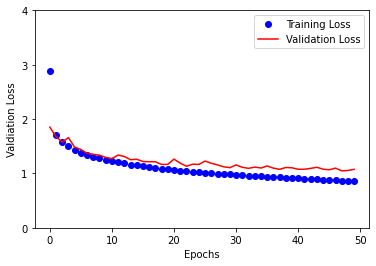

In [9]:
# Plot the loss curve
epochs = range(50)
train_loss = history.history['loss']
valid_loss = history.history['val_loss']
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, valid_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Valdiation Loss')
plt.yticks(range(0, 5))
plt.legend()
plt.show()

## 4. Train (again) and evaluate the model (5 points)

- To this end, you have found the "best" hyper-parameters. 
- Now, fix the hyper-parameters and train the network on the entire training set (all the 50K training samples)
- Evaluate your model on the test set.

### Train the model on the entire training set

Why? Previously, you used 40K samples for training; you wasted 10K samples for the sake of hyper-parameter tuning. Now you already know the hyper-parameters, so why not using all the 50K samples for training?

In [10]:
#<Compile your model again (using the same hyper-parameters you tuned above)>
model.compile(optimizer = tf.keras.optimizers.Ftrl(),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [11]:
#<Train your model on the entire training set (50K samples)>
history = model.fit(x_train, y_train_vec,
                    batch_size=256, epochs= 50,
                    validation_data=(x_test, y_test_vec))

Epoch 1/50
196/196 [==============================] - 2s 6ms/step - loss: 2.2945 - accuracy: 0.1167 - val_loss: 2.2988 - val_accuracy: 0.1439
Epoch 2/50
196/196 [==============================] - 1s 5ms/step - loss: 2.2799 - accuracy: 0.1306 - val_loss: 2.2205 - val_accuracy: 0.1687
Epoch 3/50
196/196 [==============================] - 1s 5ms/step - loss: 2.1071 - accuracy: 0.1981 - val_loss: 2.0775 - val_accuracy: 0.2283
Epoch 4/50
196/196 [==============================] - 1s 5ms/step - loss: 2.0261 - accuracy: 0.2454 - val_loss: 1.9939 - val_accuracy: 0.2654
Epoch 5/50
196/196 [==============================] - 1s 5ms/step - loss: 1.9802 - accuracy: 0.2691 - val_loss: 1.9964 - val_accuracy: 0.2764
Epoch 6/50
196/196 [==============================] - 1s 5ms/step - loss: 1.9268 - accuracy: 0.2950 - val_loss: 1.8800 - val_accuracy: 0.3175
Epoch 7/50
196/196 [==============================] - 1s 5ms/step - loss: 1.8371 - accuracy: 0.3329 - val_loss: 1.7793 - val_accuracy: 0.3602
Epoch 

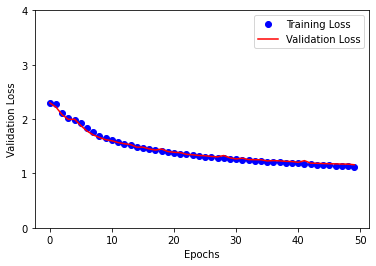

In [12]:
# Plot the loss curve
epochs = range(50)
train_loss = history.history['loss']
valid_loss = history.history['val_loss']
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, valid_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.yticks(range(0, 5))
plt.legend()
plt.show()


## 5. Evaluate the model on the test set (5 points)

Do NOT used the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [13]:
# Evaluate your model performance (testing accuracy) on testing data.
m1 = model.evaluate(x_test, y_test_vec)
print('loss = ' + str(m1[0]))
print('accuracy = ' + str(m1[1]))

313/313 [==============================] - 0s 1000us/step - loss: 1.1601 - accuracy: 0.5913
loss = 1.1601462364196777
accuracy = 0.5913000106811523


## 6. Building model with new structure (25 points)
- In this section, you can build your model with adding new layers (e.g, BN layer or dropout layer, ...).
- If you want to regularize a ```Conv/Dense layer```, you should place a ```Dropout layer``` before the ```Conv/Dense layer```.
- You can try to compare their loss curve and testing accuracy and analyze your findings.
- You need to try at lease two different model structures.

###Model 1

Epoch 1/50
157/157 [==============================] - 3s 11ms/step - loss: 5.5145 - accuracy: 0.1135 - val_loss: 2.2842 - val_accuracy: 0.1403
Epoch 2/50
157/157 [==============================] - 1s 7ms/step - loss: 2.2502 - accuracy: 0.1587 - val_loss: 2.2393 - val_accuracy: 0.1582
Epoch 3/50
157/157 [==============================] - 1s 7ms/step - loss: 2.1455 - accuracy: 0.1965 - val_loss: 2.0836 - val_accuracy: 0.2228
Epoch 4/50
157/157 [==============================] - 1s 7ms/step - loss: 2.0519 - accuracy: 0.2232 - val_loss: 1.9832 - val_accuracy: 0.2472
Epoch 5/50
157/157 [==============================] - 1s 7ms/step - loss: 2.0026 - accuracy: 0.2366 - val_loss: 1.9340 - val_accuracy: 0.2678
Epoch 6/50
157/157 [==============================] - 1s 7ms/step - loss: 1.9564 - accuracy: 0.2537 - val_loss: 1.9065 - val_accuracy: 0.2733
Epoch 7/50
157/157 [==============================] - 1s 7ms/step - loss: 1.8945 - accuracy: 0.2785 - val_loss: 1.8116 - val_accuracy: 0.3258
Epoch

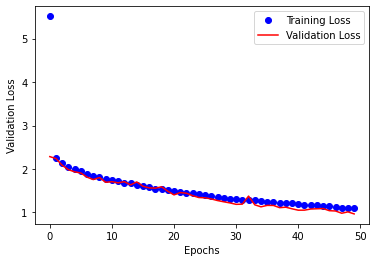

In [7]:
model1 = models.Sequential()
model1.add(layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'valid', input_shape=(32, 32, 3)))
model1.add(layers.MaxPool2D((2, 2)))
model1.add(layers.Dropout(0.6))
model1.add(layers.Conv2D(64, (4, 4), activation = 'relu', padding = 'valid'))
model1.add(layers.MaxPool2D((2, 2)))
model1.add(layers.Dropout(0.6))
model1.add(layers.Flatten())
model1.add(layers.Dense(256, activation ='relu'))
model1.add(layers.Dense(128, activation ='relu'))
model1.add(layers.Dropout(0.4))
model1.add(layers.Dense(10, activation = 'softmax'))

model1.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

history1 = model1.fit(x_tr, y_tr,
                    batch_size=256, epochs= 50,
                    validation_data=(x_val, y_val))

epochs = range(50)
train_loss = history1.history['loss']
valid_loss = history1.history['val_loss']
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, valid_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

Epoch 1/50
196/196 [==============================] - 3s 10ms/step - loss: 1.1232 - accuracy: 0.6138 - val_loss: 1.0018 - val_accuracy: 0.6478
Epoch 2/50
196/196 [==============================] - 1s 7ms/step - loss: 1.0992 - accuracy: 0.6203 - val_loss: 0.9778 - val_accuracy: 0.6681
Epoch 3/50
196/196 [==============================] - 1s 7ms/step - loss: 1.0880 - accuracy: 0.6254 - val_loss: 0.9703 - val_accuracy: 0.6663
Epoch 4/50
196/196 [==============================] - 1s 7ms/step - loss: 1.0686 - accuracy: 0.6304 - val_loss: 0.9559 - val_accuracy: 0.6793
Epoch 5/50
196/196 [==============================] - 1s 7ms/step - loss: 1.0680 - accuracy: 0.6336 - val_loss: 0.9467 - val_accuracy: 0.6883
Epoch 6/50
196/196 [==============================] - 1s 7ms/step - loss: 1.0590 - accuracy: 0.6375 - val_loss: 0.9535 - val_accuracy: 0.6765
Epoch 7/50
196/196 [==============================] - 1s 7ms/step - loss: 1.0491 - accuracy: 0.6383 - val_loss: 0.9339 - val_accuracy: 0.6761
Epoch

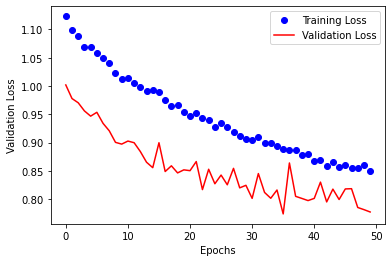

In [8]:
model1.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

history1 = model1.fit(x_train, y_train_vec,
                    batch_size=256, epochs= 50,
                    validation_data=(x_test, y_test_vec))

epochs = range(50)
train_loss = history1.history['loss']
valid_loss = history1.history['val_loss']
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, valid_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

In [16]:
m2 = model1.evaluate(x_test, y_test_vec)
print('loss = ' + str(m2[0]))
print('accuracy = ' + str(m2[1]))

313/313 [==============================] - 0s 1ms/step - loss: 0.8328 - accuracy: 0.7514
loss = 0.832772433757782
accuracy = 0.7513999938964844


###Model 2

Epoch 1/50
157/157 [==============================] - 2s 8ms/step - loss: 5.7873 - accuracy: 0.2380 - val_loss: 2.6621 - val_accuracy: 0.2827
Epoch 2/50
157/157 [==============================] - 1s 5ms/step - loss: 2.3428 - accuracy: 0.3108 - val_loss: 2.2220 - val_accuracy: 0.3203
Epoch 3/50
157/157 [==============================] - 1s 5ms/step - loss: 2.0404 - accuracy: 0.3499 - val_loss: 2.0135 - val_accuracy: 0.3485
Epoch 4/50
157/157 [==============================] - 1s 5ms/step - loss: 1.8766 - accuracy: 0.3767 - val_loss: 1.8868 - val_accuracy: 0.3633
Epoch 5/50
157/157 [==============================] - 1s 5ms/step - loss: 1.7744 - accuracy: 0.3979 - val_loss: 1.8235 - val_accuracy: 0.3821
Epoch 6/50
157/157 [==============================] - 1s 5ms/step - loss: 1.6998 - accuracy: 0.4150 - val_loss: 1.7562 - val_accuracy: 0.3982
Epoch 7/50
157/157 [==============================] - 1s 5ms/step - loss: 1.6428 - accuracy: 0.4305 - val_loss: 1.7045 - val_accuracy: 0.4149
Epoch 

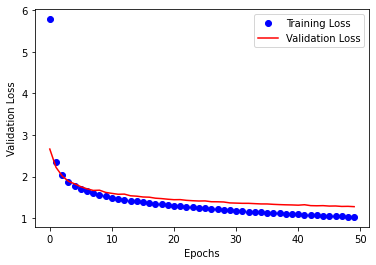

In [10]:
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'valid', input_shape=(32, 32, 3)))
model2.add(layers.MaxPool2D((2, 2)))
model2.add(layers.Normalization())
model2.add(layers.Conv2D(64, (4, 4), activation = 'relu', padding = 'valid'))
model2.add(layers.MaxPool2D((2, 2)))
model2.add(layers.Normalization())
model2.add(layers.Flatten())
model2.add(layers.Dense(256, activation ='relu'))
model2.add(layers.Normalization())
model2.add(layers.Dense(10, activation = 'softmax'))

model2.compile(optimizer = tf.keras.optimizers.Adagrad() ,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

history2 = model2.fit(x_tr, y_tr,
                    batch_size=256, epochs= 50,
                    validation_data=(x_val, y_val))

epochs = range(50)
train_loss = history2.history['loss']
valid_loss = history2.history['val_loss']
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, valid_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

Epoch 1/50
196/196 [==============================] - 2s 6ms/step - loss: 2.1054 - accuracy: 0.2024 - val_loss: 2.0490 - val_accuracy: 0.2329
Epoch 2/50
196/196 [==============================] - 1s 5ms/step - loss: 2.0161 - accuracy: 0.2500 - val_loss: 1.9958 - val_accuracy: 0.2675
Epoch 3/50
196/196 [==============================] - 1s 5ms/step - loss: 1.9743 - accuracy: 0.2722 - val_loss: 1.9691 - val_accuracy: 0.2827
Epoch 4/50
196/196 [==============================] - 1s 5ms/step - loss: 1.9311 - accuracy: 0.2930 - val_loss: 1.9058 - val_accuracy: 0.3057
Epoch 5/50
196/196 [==============================] - 1s 5ms/step - loss: 1.8767 - accuracy: 0.3174 - val_loss: 1.8459 - val_accuracy: 0.3343
Epoch 6/50
196/196 [==============================] - 1s 5ms/step - loss: 1.8209 - accuracy: 0.3402 - val_loss: 1.8021 - val_accuracy: 0.3517
Epoch 7/50
196/196 [==============================] - 1s 5ms/step - loss: 1.7708 - accuracy: 0.3623 - val_loss: 1.7412 - val_accuracy: 0.3721
Epoch 

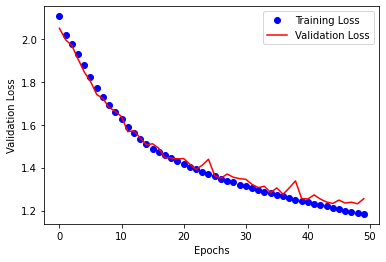

In [12]:
model2.compile(optimizer = tf.keras.optimizers.Adagrad(),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

history2 = model2.fit(x_train, y_train_vec,
                    batch_size=256, epochs= 50,
                    validation_data=(x_test, y_test_vec))

epochs = range(50)
train_loss = history2.history['loss']
valid_loss = history2.history['val_loss']
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, valid_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

In [19]:
m3 = model2.evaluate(x_test, y_test_vec)
print('loss = ' + str(m3[0]))
print('accuracy = ' + str(m3[1]))

313/313 [==============================] - 1s 2ms/step - loss: 1.2841 - accuracy: 0.5408
loss = 1.284069538116455
accuracy = 0.5407999753952026


###Model 3

Epoch 1/75
157/157 [==============================] - 2s 7ms/step - loss: 5.2642 - accuracy: 0.2101 - val_loss: 2.0531 - val_accuracy: 0.2363
Epoch 2/75
157/157 [==============================] - 1s 5ms/step - loss: 1.8552 - accuracy: 0.3360 - val_loss: 1.9191 - val_accuracy: 0.3132
Epoch 3/75
157/157 [==============================] - 1s 5ms/step - loss: 1.7355 - accuracy: 0.3819 - val_loss: 1.8396 - val_accuracy: 0.3370
Epoch 4/75
157/157 [==============================] - 1s 5ms/step - loss: 1.6529 - accuracy: 0.4101 - val_loss: 1.7971 - val_accuracy: 0.3522
Epoch 5/75
157/157 [==============================] - 1s 5ms/step - loss: 1.5923 - accuracy: 0.4323 - val_loss: 1.6091 - val_accuracy: 0.4181
Epoch 6/75
157/157 [==============================] - 1s 5ms/step - loss: 1.5501 - accuracy: 0.4482 - val_loss: 1.7240 - val_accuracy: 0.3985
Epoch 7/75
157/157 [==============================] - 1s 5ms/step - loss: 1.5142 - accuracy: 0.4631 - val_loss: 1.5961 - val_accuracy: 0.4318
Epoch 

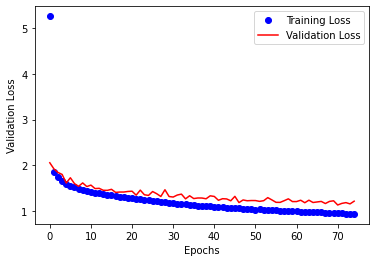

In [28]:
model3 = models.Sequential()
model3.add(layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'valid', input_shape=(32, 32, 3)))
model3.add(layers.MaxPool2D((2, 2)))
model3.add(layers.Dropout(0.1))
model3.add(layers.Conv2D(64, (4, 4), activation = 'relu', padding = 'valid'))
model3.add(layers.MaxPool2D((2, 2)))
model3.add(layers.Flatten())
model3.add(layers.Dense(256, activation ='relu'))
model3.add(layers.Dense(10, activation = 'softmax'))

model3.compile(optimizer = tf.keras.optimizers.Ftrl() ,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

history3 = model3.fit(x_tr, y_tr,
                    batch_size=256, epochs= 75,
                    validation_data=(x_val, y_val))

epochs = range(75)
train_loss = history3.history['loss']
valid_loss = history3.history['val_loss']
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, valid_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

Epoch 1/75
196/196 [==============================] - 2s 7ms/step - loss: 2.2953 - accuracy: 0.1030 - val_loss: 2.3025 - val_accuracy: 0.1000
Epoch 2/75
196/196 [==============================] - 1s 5ms/step - loss: 2.3024 - accuracy: 0.1000 - val_loss: 2.3023 - val_accuracy: 0.1000
Epoch 3/75
196/196 [==============================] - 1s 5ms/step - loss: 2.3021 - accuracy: 0.1000 - val_loss: 2.3017 - val_accuracy: 0.1000
Epoch 4/75
196/196 [==============================] - 1s 5ms/step - loss: 2.3005 - accuracy: 0.1000 - val_loss: 2.2980 - val_accuracy: 0.1000
Epoch 5/75
196/196 [==============================] - 1s 5ms/step - loss: 2.2897 - accuracy: 0.1009 - val_loss: 2.2751 - val_accuracy: 0.1068
Epoch 6/75
196/196 [==============================] - 1s 5ms/step - loss: 2.2313 - accuracy: 0.1283 - val_loss: 2.1891 - val_accuracy: 0.1662
Epoch 7/75
196/196 [==============================] - 1s 5ms/step - loss: 2.1179 - accuracy: 0.2007 - val_loss: 2.0562 - val_accuracy: 0.2297
Epoch 

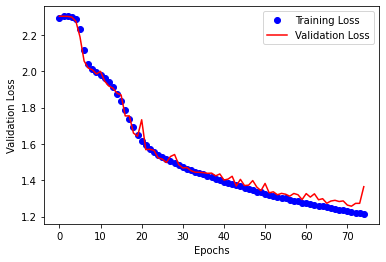

In [29]:
model3.compile(optimizer = tf.keras.optimizers.Ftrl() ,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

history3 = model3.fit(x_train, y_train_vec,
                    batch_size=256, epochs= 75,
                    validation_data=(x_test, y_test_vec))

epochs = range(75)
train_loss = history3.history['loss']
valid_loss = history3.history['val_loss']
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, valid_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()